In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, RandomRotation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available


In [3]:
csv_path = "/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv"
df = pd.read_csv(csv_path)
df['dx'] = df['dx'].replace('bkl', 0)
df['dx'] = df['dx'].replace('nv', 1)
df['dx'] = df['dx'].replace('mel', 2)
df['dx'] = df['dx'].replace('df', 3)
df['dx'] = df['dx'].replace('vasc', 4)
df['dx'] = df['dx'].replace('bcc', 5)
df['dx'] = df['dx'].replace('akiec', 6)
print(df.head(5))
num_classes = df['dx'].nunique()
print(num_classes)

     lesion_id      image_id  dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419   0   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030   0   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769   0   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661   0   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633   0   histo  75.0  male          ear
7


/tmp/ipykernel_34/4210159419.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['dx'] = df['dx'].replace('akiec', 6)


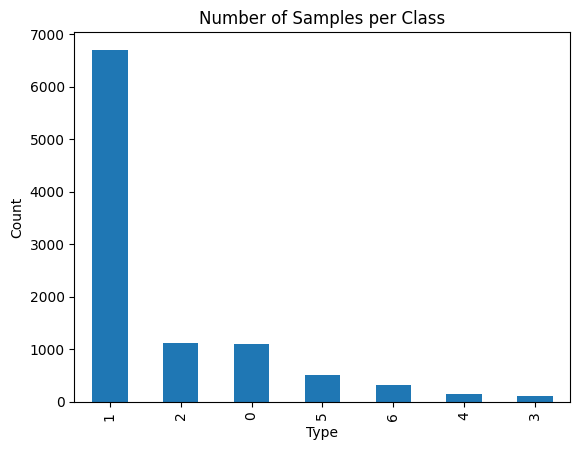

In [4]:
class_counts = df['dx'].value_counts()
class_counts.plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Number of Samples per Class')
plt.show()

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=4)
print(train_df.head(5))

        lesion_id      image_id  dx    dx_type   age     sex     localization
7273  HAM_0005298  ISIC_0029662   1      histo  50.0  female             foot
7345  HAM_0004829  ISIC_0034042   1      histo  45.0  female  lower extremity
9523  HAM_0005689  ISIC_0028066   1  consensus  20.0    male             back
2767  HAM_0005536  ISIC_0026798   5      histo  45.0    male  lower extremity
107   HAM_0001665  ISIC_0027957   0      histo  50.0    male  lower extremity


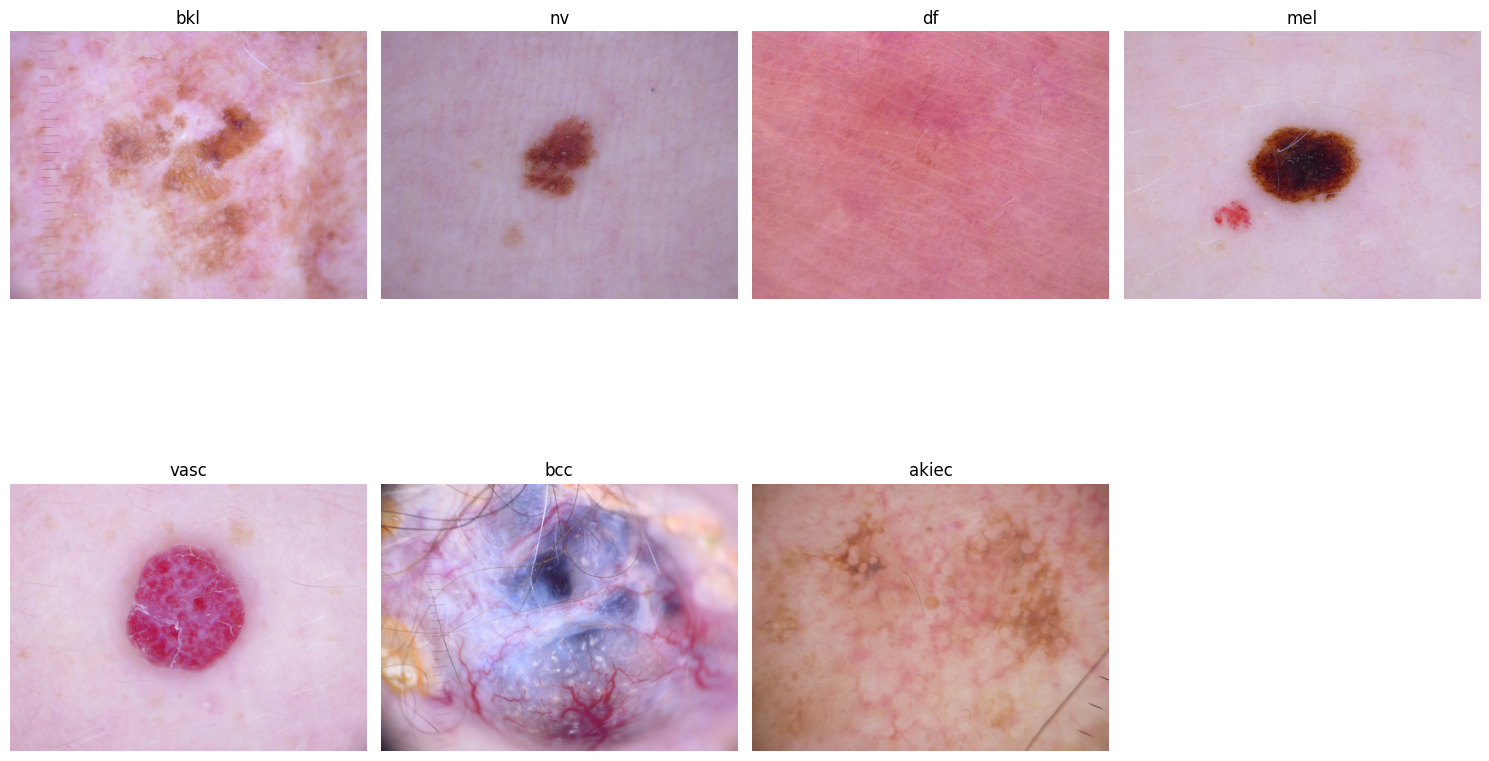

In [6]:
bkl='/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0027419.jpg'
nv='/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0024698.jpg'
df='/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0027044.jpg'
mel='/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0030623.jpg'
vasc='/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0031197.jpg'
bcc='/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0026321.jpg'
akiec='/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0028393.jpg'
image_paths = {
    'bkl': bkl,
    'nv': nv,
    'df': df,
    'mel': mel,
    'vasc': vasc,
    'bcc': bcc,
    'akiec': akiec
}

plt.figure(figsize=(15, 10))
for i, (name, path) in enumerate(image_paths.items()):
    img = mpimg.imread(path)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
ros = RandomOverSampler(random_state=42)
train_resampled, train_labels_resampled = ros.fit_resample(train_df, train_df['dx'])

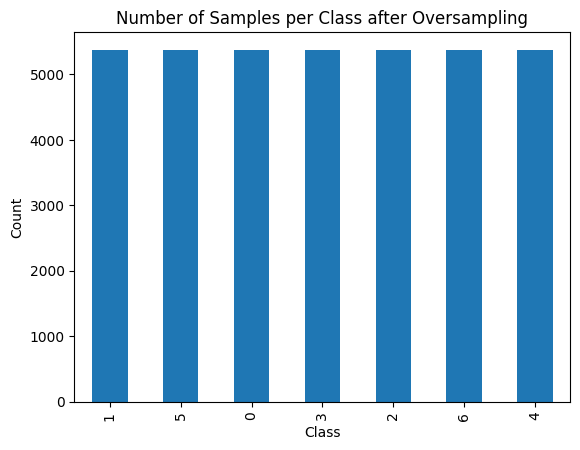

In [8]:
train_resampled_df = train_resampled.copy()
train_resampled_df['dx'] = train_labels_resampled

# 计算过采样后每个类别的数量
resampled_counts = train_resampled_df['dx'].value_counts()

# 绘制每个类别数量的柱状图
resampled_counts.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Samples per Class after Oversampling')

plt.show()

In [9]:
image_folder = '/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer'

In [10]:
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None, augment=False):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform
        self.augment = augment
        self.aug_transform = transforms.Compose([
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomRotation(30),
            ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        ])
        # Filter out rows with missing images
        self.valid_indices = self._filter_valid_indices()

    def _filter_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.dataframe)):
            row = self.dataframe.iloc[idx]
            image_name = row['image_id'] + '.jpg'
            image_path = os.path.join(self.image_folder, image_name)
            if os.path.exists(image_path):
                valid_indices.append(idx)
            else:
                print(f"Error loading image: {image_path}")
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.dataframe.iloc[actual_idx]
        image_name = row['image_id'] + '.jpg'
        label = row['dx']
        image_path = os.path.join(self.image_folder, image_name)
        image = cv2.imread(image_path)
        if image is None:
            raise RuntimeError(f"Error loading image that should exist: {image_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        image = Image.fromarray(image)

        if self.augment:
            image = self.aug_transform(image)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
train_dataset = SkinLesionDataset(train_resampled, image_folder, transform=transform, augment=True)
test_dataset = SkinLesionDataset(test_df, image_folder, transform=transform)
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True,
                          collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True,
                        collate_fn=collate_fn)

In [12]:
epochs = 30
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# 定义准确函数
def accuracy(output, target):
    pred = output.argmax(dim=1)
    correct = torch.eq(pred, target).float().sum().item()
    return correct
model = ResNet50(num_classes=num_classes).to(device)
class_weights = torch.tensor([1.0] * num_classes, dtype=torch.float).to(device) 
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s] 


In [14]:
best_test_accuracy = 0.0
model_save_dir = '/kaggle/working/'
model_save_path = os.path.join(model_save_dir, 'best_model.pth')
for epoch in range(epochs):
    model.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_correct += accuracy(outputs, labels)
        train_total += labels.size(0)
    
    train_accuracy = train_correct / train_total
    print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}')
    
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            test_correct += accuracy(outputs, labels)
            test_total += labels.size(0)
    
    test_accuracy = test_correct / test_total
    print(f'Epoch {epoch+1}/{epochs}, Test Accuracy: {test_accuracy:.4f}')
    
    # 如果当前测试集准确率优于之前的最优准确率，则保存当前模型参数
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f'Saved best model with accuracy: {test_accuracy:.4f}')
    
    scheduler.step()

print(f'Best test accuracy: {best_test_accuracy:.4f}')

Epoch 1/30, Train Accuracy: 0.7062
Epoch 1/30, Test Accuracy: 0.7289
Saved best model with accuracy: 0.7289
Epoch 2/30, Train Accuracy: 0.7582
Epoch 2/30, Test Accuracy: 0.7044
Epoch 3/30, Train Accuracy: 0.7942
Epoch 3/30, Test Accuracy: 0.7469
Saved best model with accuracy: 0.7469
Epoch 4/30, Train Accuracy: 0.8199
Epoch 4/30, Test Accuracy: 0.6975
Epoch 5/30, Train Accuracy: 0.8429
Epoch 5/30, Test Accuracy: 0.7748
Saved best model with accuracy: 0.7748
Epoch 6/30, Train Accuracy: 0.8567
Epoch 6/30, Test Accuracy: 0.7329
Epoch 7/30, Train Accuracy: 0.8740
Epoch 7/30, Test Accuracy: 0.7409
Epoch 8/30, Train Accuracy: 0.8871
Epoch 8/30, Test Accuracy: 0.7499
Epoch 9/30, Train Accuracy: 0.8972
Epoch 9/30, Test Accuracy: 0.7389
Epoch 10/30, Train Accuracy: 0.9031
Epoch 10/30, Test Accuracy: 0.7843
Saved best model with accuracy: 0.7843
Epoch 11/30, Train Accuracy: 0.9439
Epoch 11/30, Test Accuracy: 0.8258
Saved best model with accuracy: 0.8258
Epoch 12/30, Train Accuracy: 0.9534
Epoch 